In [1]:
import numpy as np
import os
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import sys
from pathlib import Path
from scipy.signal import butter, lfilter

import json
import commentjson
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np
        

In [2]:
def parse_txt(text_lines):
    time, ch1, ch2 = [], [], []
    for i, line in enumerate(text_lines):
        if i < 6:
            continue
        line = line.split("; ")
        try:
            time.append(float(line[0]))
            ch1.append(float(line[1]))
            ch2.append(float(line[2]))
        except:
            print("End line at {} ".format(i))
            break
    return np.asarray(time), np.asarray(ch1), np.asarray(ch2)

def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]
    
def cyc_searching (data,window):
    temp_max =0 ;
    i=0
    ind_min= 0;
    ind_max=0;
    A = data[0:window];
    B = data[window+1:2*window+1];
    if((np.max(B)-np.max(A))>0):
        direct ="up";
    else:
        direct = "down"
    collect = []
    while(1):
        A = data[i:i+window];
        B = data[i+window+1:i+2*window+1];
        if ((np.max(B)-np.max(A)) == 0): i=i+window;
        if(direct == "up"):
            #start collect
            if((np.max(B)-np.max(A))>0):       
                i=i+window;
                if((i+2*window+1)>len(data)): return collect;
            else:            
                ind_max=i+np.argmax(A)
                direct = "down";
                
        if(direct == "down"):        
            if((np.min(A)- np.min(B))>0):
                i=i+window;
                if((i+2*window+1)>len(data)): return  collect;
            else:
                ind_min=i+np.argmin(A)
                collect.append([ind_max,ind_min])
                direct = "up"

In [3]:
#generate data
data_path = "../data/meas_scope_20210823.txt"
time, raw_data, triangle_waves = parse_txt(load_text(data_path))
root_dir = os.path.split(data_path)[0]



In [4]:
window = 5000
pzt_ind = cyc_searching(triangle_waves,window)

print("get ",len(pzt_ind)," cycles")

get  29  cycles


In [5]:
pzt_ind

[[119496, 260101],
 [400687, 541377],
 [681949, 822650],
 [963225, 1103915],
 [1244472, 1385157],
 [1525730, 1666394],
 [1807048, 1947530],
 [2088290, 2228894],
 [2369490, 2510139],
 [2650736, 2791416],
 [2931963, 3072603],
 [3213291, 3353969],
 [3494489, 3635113],
 [3775834, 3916298],
 [4056907, 4197578],
 [4338238, 4478929],
 [4619632, 4760190],
 [4900720, 5041305],
 [5182099, 5322578],
 [5463230, 5603928],
 [5744624, 5885145],
 [6025744, 6166381],
 [6307023, 6447645],
 [6588315, 6728892],
 [6869451, 7010011],
 [7150637, 7291425],
 [7431953, 7572668],
 [7713228, 7853861],
 [7994484, 8135145]]

# Load 柏安 signal-det

In [6]:
signal_det_path = "../data/det_idxs.npy"
det_peaks= np.load(signal_det_path )

# Simulator

In [7]:
def package_generator(pzt_ind, det_peaks):
    ds_gen = []
    for num in range(len(pzt_ind)):
        
        first_ind = pzt_ind[num][0]
        final_ind = pzt_ind[num][1]        
        tmp_peaks=[]
        for peak in det_peaks:
            if ((peak>first_ind) & (peak < final_ind)):
                tmp_peaks.append((peak-first_ind))
                
        ds_gen.append(tmp_peaks)
        
    return ds_gen
    
def create_peaks(ds,size):
    vs = np.zeros(size)
    i=0;
    for i in range(len(ds)):        
        vs[ds[i]] = 1        
    return vs

In [8]:
# A simulator for SSF test, like a real-time data input
ds_gen = package_generator(pzt_ind,det_peaks)

# Programming SSF

In [9]:
# at t
# ds(t) = ds_gen[t]
# ds 資料結構: (one scan)
# 
#  [ x1,x2,x3,x4.... ] 
#
# comb space 需有上下限
# in the case, I supposed 5000(up) and 1000(down)
#
#
#  state = [x, x_var, c, c_var]
#  x     = offest point(initial point)
#  x_var = variance of x
#  c     = comb space
#  c_var = variance of comb space
#

In [10]:
class SSF:
    def __init__(self,x0,combspace,size):
        self.x0 = x0
        self.x0_var = 0xffff
        self.x = np.arange(x0,size,combspace)
        self.x_active = np.zeros(len(self.x))
        self.x_var = np.ones(len(self.x))*0xff
        self.c = combspace
        self.c_var = 500
        self.ds =[]
        self.size =size
        self.start =0
    def predict(self):
        ##################
        #
        # To do : how to predict the state of x and c
        #
        ######################
        if (self.start):
            up_lim = 5000
            down_lim = 1000
            delta = 0
            c = []
            c_ave =0
            x0_ave = 0
            c_std =0
            x0_std = 0
            for i in range(len(self.x)-1):
                if(self.x_active[i]):    
                    #self.x_active[i] = 0
                    for j in range(len(self.x)-1 - i):
                        if(self.x_active[i+j+1]):  
                            #self.x_active[i+j+1] =0
                            delta = self.x[i+j+1] - self.x[i]
                            if ((delta > down_lim) & (delta <up_lim)):
                                c.append(delta)




            c_ave = round(np.average(c))
            c_std = round(np.std(c))
            x0 =[] 
            for i in range(len(self.x)):
                if(self.x_active[i]):
                    x = self.x[i]
                    while(x>c_ave):
                        x = x - c_ave
                    x0.append(x)
            x0_ave = round(np.average(x0))       
            x0_std = round(np.std(x0))

            if((x0_ave !=0) & (c_ave !=0)):
                self.x0 = x0_ave
                self.x0_var = x0_std 
                self.x = np.arange(self.x0,self.size,c_ave)
                self.c = c_ave
                self.c_var = c_std
                #not sure whether need to reset that
                self.x_active = np.zeros(len(self.x))
                return 1
        return 0
        
        
    def get_measu (self,ds):
        self.ds=ds
        
    
    def update(self,window):
        search_zone = 5
        ds_var = 20
        update_count=0
        self.start = 1
        for i in range(len(self.ds)):
            # find near peaks of prediction: 
            # warning: 如果剛好在正中間，選小的
            
            near_pt = round((self.ds[i]-self.x0)/self.c)
            
            ans = []
            for j in range(len(self.x)):
                delta = abs(self.ds[i]-self.x[j])
                ans.append(delta)
            min_delta = min(ans)    
            near_pt = ans.index(min_delta)
            if( min_delta  < window):                
                self.x_active[near_pt] = 1
                self.x[near_pt] = round((self.x[near_pt] * self.x_var[near_pt] + self.ds[i]* ds_var )/(self.x_var[near_pt] + ds_var ))
                self.x_var[near_pt] = round( 1/(1/self.x_var[near_pt]+1/ds_var)) + random.random()*30 #add dither
                update_count = update_count +1
        #print('active',sum(self.x_active),len(self.ds))
        return update_count
    
    def create_predict_peaks(self,size):
        vs = np.zeros(size)
        i=0;
        vs[self.x0] =1
        for i in range(len(self.x)):           
            vs[self.x] = 1
        return vs

In [11]:
#initialize...
u = SSF(1500,3000,150000)

# assign round n
n=10
for i in range(n):
    u.predict()
    u.get_measu(ds_gen[n])
    u.update(3000)
    print("round",i,u.x0,u.c)



round 0 1500 3000
round 1 1261 3012
round 2 1190 3064
round 3 2017 3010
round 4 1746 3507
round 5 1688 3513
round 6 1437 3540
round 7 1360 3540
round 8 1553 3572
round 9 1598 3683


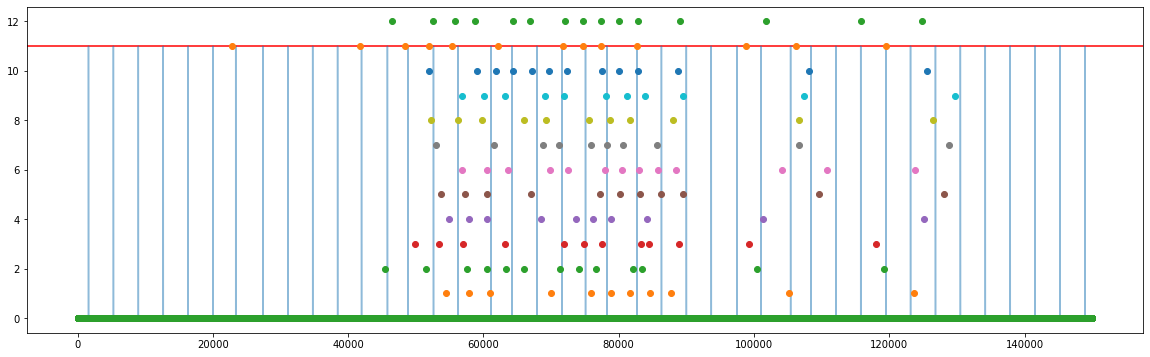

In [12]:
data_len = 150000
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
vs = u.create_predict_peaks(data_len)
plt.plot(x,vs*(n+1),alpha = 0.5)
for num in range(n+2):
    y = create_peaks(ds_gen[num],data_len) *(num+1)
    plt.plot(x,y, 'o')   

round 0 1500 3000
round 1 1188 3012
round 2 1843 3065
round 3 2338 3150
round 4 897 3243
round 5 1581 3215
round 6 1733 3208
round 7 1885 3202
round 8 2236 3187
round 9 2286 3185
round 10 2015 3196
round 11 1865 3202
round 12 2046 3195
round 13 2206 3188
round 14 2499 3176
round 15 2573 3173
round 16 2536 3174
round 17 2421 3179
round 18 2012 3196
round 19 1881 3202


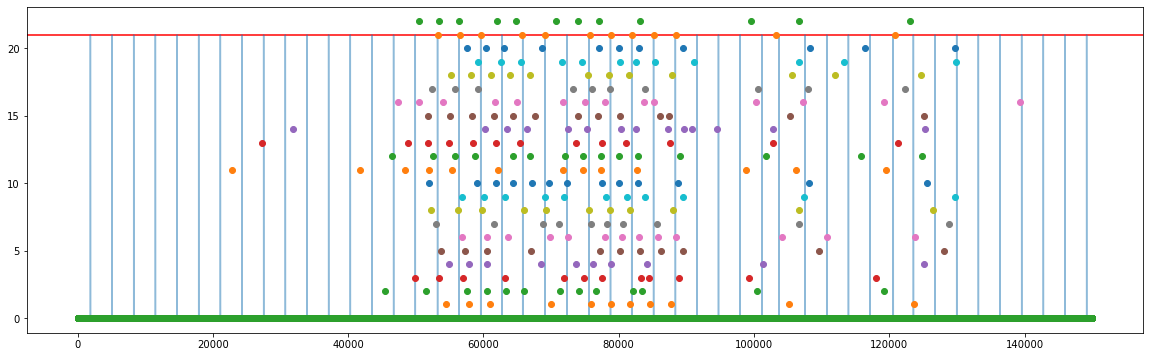

In [13]:
#initialize...
u = SSF(1500,3000,150000)

# assign round n
n=20
for i in range(n):
    u.predict()
    u.get_measu(ds_gen[n])
    u.update(3000)
    print("round",i,u.x0,u.c)
    
data_len = 150000
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
vs = u.create_predict_peaks(data_len)
plt.plot(x,vs*(n+1),alpha = 0.5)
for num in range(n+2):
    y = create_peaks(ds_gen[num],data_len) *(num+1)
    plt.plot(x,y, 'o')   

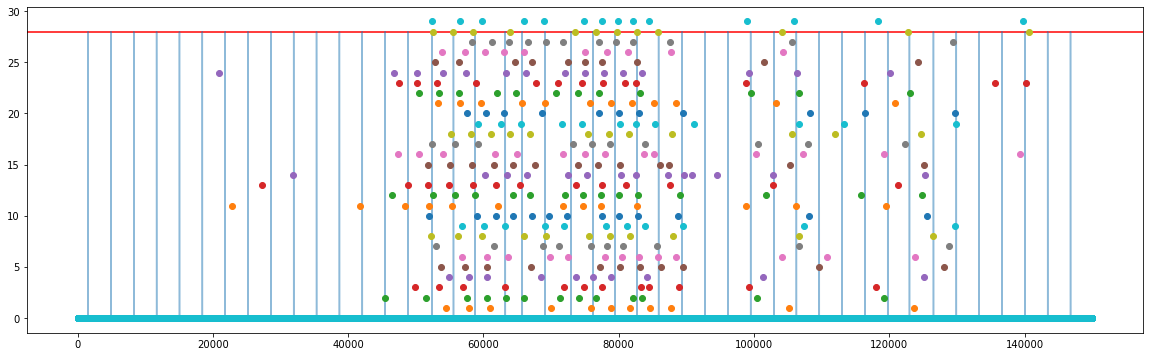

In [14]:
#initialize...
u = SSF(1500,3000,150000)

# assign round n
n=27
for i in range(n):
    u.predict()
    u.get_measu(ds_gen[n])
    u.update(3000)
    
data_len = 150000
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
vs = u.create_predict_peaks(data_len)
plt.plot(x,vs*(n+1),alpha = 0.5)
for num in range(n+2):
    y = create_peaks(ds_gen[num],data_len) *(num+1)
    plt.plot(x,y, 'o')   